In [128]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import string, sys
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt

stem_begin, stem_end = '⋊', '⋉'
syms = ['ε',stem_begin,] + [x for x in string.ascii_lowercase] + [stem_end,]

main_dir = '/Users/colin/Desktop/'
params = torch.load(main_dir +'encoder_decoder_params.pt')
stem_ids = torch.load(main_dir +'stem_ids.pt')
stem_encs = torch.load(main_dir +'stem_encs.pt')
dec_states = torch.load(main_dir +'dec_states.pt')
dec_attns = torch.load(main_dir +'dec_attns.pt')

print ('stem_ids:', stem_ids.shape)
print ('stem_encs:', stem_encs.shape)
print ('dec_states:', dec_states.shape)
print ('dec_attns:', dec_attns.shape)
print ('done')

stem_ids: torch.Size([9, 451, 1])
stem_encs: torch.Size([9, 451, 100])
dec_states: torch.Size([12, 451, 100])
dec_attns: torch.Size([12, 451, 9])
done


In [19]:
# list model parameters
for param_tensor in params:
    print(param_tensor, "\t", params[param_tensor].size())

embedding.embedding.weight 	 torch.Size([29, 29])
encoder.embeddings.embedding.weight 	 torch.Size([29, 29])
encoder.rnn.weight_ih_l0 	 torch.Size([150, 29])
encoder.rnn.weight_hh_l0 	 torch.Size([150, 50])
encoder.rnn.bias_ih_l0 	 torch.Size([150])
encoder.rnn.bias_hh_l0 	 torch.Size([150])
encoder.rnn.weight_ih_l0_reverse 	 torch.Size([150, 29])
encoder.rnn.weight_hh_l0_reverse 	 torch.Size([150, 50])
encoder.rnn.bias_ih_l0_reverse 	 torch.Size([150])
encoder.rnn.bias_hh_l0_reverse 	 torch.Size([150])
decoder.embedding.embedding.weight 	 torch.Size([29, 29])
decoder.Ws.weight 	 torch.Size([100, 100])
decoder.Ws.bias 	 torch.Size([100])
decoder.Wz.weight 	 torch.Size([100, 229])
decoder.Wz.bias 	 torch.Size([100])
decoder.Wr.weight 	 torch.Size([100, 229])
decoder.Wr.bias 	 torch.Size([100])
decoder.Wp.weight 	 torch.Size([100, 229])
decoder.Wp.bias 	 torch.Size([100])
decoder.Wa.weight 	 torch.Size([100, 200])
decoder.Wa.bias 	 torch.Size([100])
decoder.va.weight 	 torch.Size([1, 100

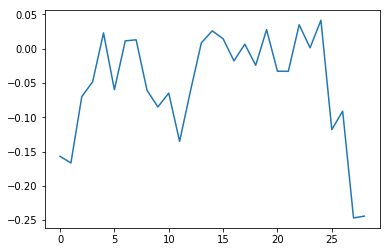

   sym      bias
24   w  0.041367
22   u  0.034768
19   r  0.027676
14   m  0.025906
4    c  0.022904
15   n  0.014427
7    f  0.012833
6    e  0.011302
13   l  0.008384
17   p  0.006443
23   v  0.001210
16   o -0.017828
18   q -0.024297
20   s -0.032952
21   t -0.033088
3    b -0.048311
5    d -0.059901
8    g -0.060687
12   k -0.061568
10   i -0.064896
2    a -0.069974
9    h -0.084986
26   y -0.091192
25   x -0.118048
11   j -0.135266
0    ε -0.157080
1    ⋊ -0.166685
28   ⋉ -0.244191
27   z -0.246805


In [20]:
# inspect generator parameters
plt.plot(params['generator.0.bias'].data.numpy())
plt.show()

dat = pd.DataFrame({
    'sym':syms,
    'bias':params['generator.0.bias'].data.numpy()
})
dat = dat.sort_values('bias', ascending=False)
print (dat)

#plt.matshow(params['generator.0.weight'].data.numpy())
#plt.show()

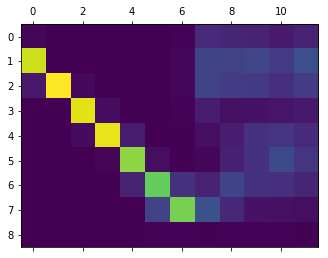

In [21]:
# attention distribution for one example
# (rows: stem positions, columns: output positions)
plt.matshow(dec_attns[:,0,:].data.numpy().T)
plt.show()

[0.001 0.001 0.001 0.001 0.001 0.992 0.001 0.001 0.001 0.001]


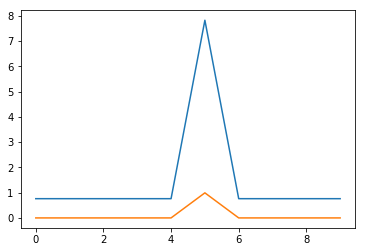

In [23]:
# position-based attention distribution -- hypothetical
v = np.ones(10).T
Wa_s = np.eye(10)[:,5]
Ua_h = np.eye(10)
e = v @ np.tanh(Wa_s + Ua_h)
plt.plot(e)
alpha = np.exp(e)
alpha /= sum(alpha)
print (np.round(alpha, 3))
plt.plot(alpha)
plt.show()

torch.Size([100, 200]) torch.Size([100]) torch.Size([1, 100])
torch.Size([9, 451, 100])
(4059, 4059)


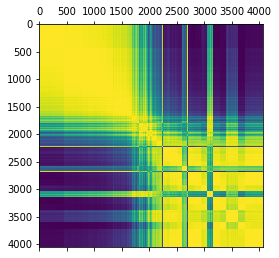

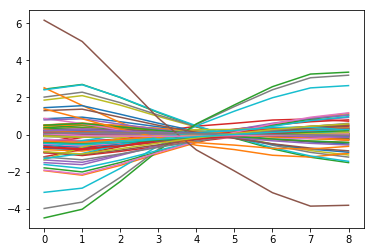

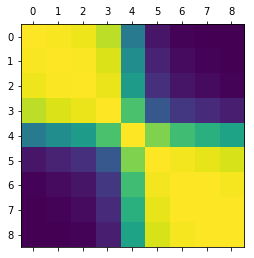

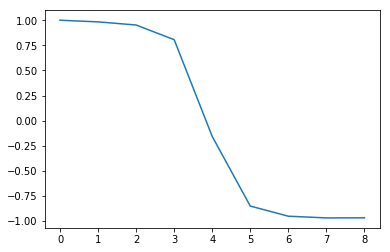

In [133]:
# # # # # # # # # #
# Functional decomposition of role (ordinal position) representations
# source positions
stem_len, batch_len, hidden_dim = stem_encs.shape

Wa = params['decoder.Wa.weight']
ba = params['decoder.Wa.bias']
va = params['decoder.va.weight']
print (Wa.shape, ba.shape, va.shape)

# extract (putative) position encoding of stem symbols
stem_posn_map = nn.Linear(hidden_dim, hidden_dim, bias=False)
stem_posn_map.weight = nn.Parameter(Wa[:,100:])
stem_posns = stem_posn_map(stem_encs)
#stem_posns = stem_posn_map(dec_states)
print (stem_posns.shape)

# group by input position
posn_indx = [i for i in np.repeat([k for k in range(stem_len)], batch_len)]
batch_indx = [k for k in range(batch_len)] * stem_len
tmp = stem_posns.contiguous().view(-1, hidden_dim).data.numpy()
stem_posn_sims = 1.0 - squareform(pdist(tmp, 'cosine'))
tmp = stem_ids.contiguous().view(-1, 1).data.numpy()
mask = [tmp[k,0]!=0 for k in range(tmp.shape[0])]
#stem_posn_sims = stem_posn_sims[mask,:]
#stem_posn_sims = stem_posn_sims[:,mask]
print (stem_posn_sims.shape)
plt.matshow(stem_posn_sims)
plt.show()

# position vector averages
stem_posn_mus = []
for i in range(stem_len):
    mask = [j for j in range(batch_len) if stem_ids[i,j,0]!=0]
    posns = stem_posns[i,mask,:]
    posn_mu = torch.mean(posns, 0, keepdim=True)
    stem_posn_mus.append(posn_mu)
stem_posn_mus = torch.cat(stem_posn_mus, 0).data.numpy()
# avg position representations
plt.plot(stem_posn_mus)
plt.show()
# similarities of avg position representations
posn_mu_sims = 1.0 - squareform(pdist(stem_posn_mus, 'cosine'))
plt.matshow(posn_mu_sims)
plt.show()
# similarities of avg position representations
plt.plot(posn_mu_sims[0,:])
plt.show()

torch.Size([100, 229]) torch.Size([100])
torch.Size([4059, 100])
(29, 100)


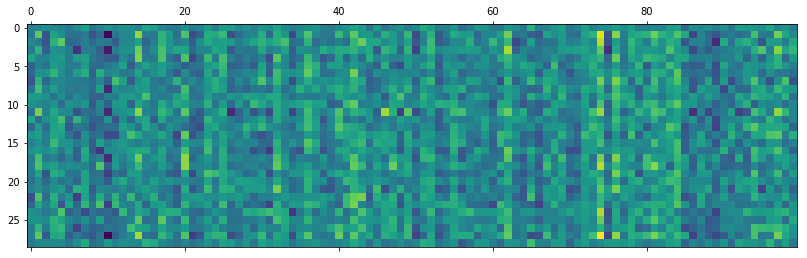

In [168]:
# # # # # # # # # #
# Functional decomposition of identity (character) representations
stem_len, batch_len, hidden_dim = stem_encs.shape

Wo = params['decoder.Wo.weight']
bo = params['decoder.Wo.bias']
print (Wo.shape, bo.shape)

# extract (putative) identity encoding of stem symbols
stem_ident_map = nn.Linear(hidden_dim, hidden_dim, bias=False)
stem_ident_map.weight = nn.Parameter(Wo[:,(29+100):])
stem_idents = stem_ident_map(stem_encs)
stem_idents = stem_idents.contiguous().view(-1, hidden_dim)
print (stem_idents.shape)
stem_ids_ = [x[0] for x in stem_ids.contiguous().view(-1,1).data.numpy()]
#indx = np.argsort(stem_ids_)
#print (indx)
#stem_ids_ = stem_ids_[indx]
#stem_idents = stem_idents[indx,:]
#plt.matshow(stem_idents.T)
#plt.show()

# identity vector averages
stem_ident_mus = []
for i in range(len(syms)):
    mask = [k for k in range(len(stem_ids_)) if stem_ids_[k] == i]
    idents = stem_idents[mask,:]
    ident_mu = torch.mean(idents, 0, keepdim=True)
    stem_ident_mus.append(ident_mu)
stem_ident_mus = torch.cat(stem_ident_mus, 0).data.numpy()
print (stem_ident_mus.shape)
plt.matshow(stem_ident_mus)
plt.show()


In [131]:
# # # # # # # # # #
# Functional decomposition of filler (character) representations
dim = 50
tgt_len = 14
src_batch = 32

linear_out = nn.Linear(dim*2, dim, bias=True)
linear_out.weight = nn.Parameter(
    params['decoder.attn.linear_out.weight'])
linear_out.bias = nn.Parameter(
    params['decoder.attn.linear_out.bias'])

generator = nn.Linear(dim, len(syms), bias=True)
generator.weight = nn.Parameter(
    params['generator.0.weight'])
generator.bias = nn.Parameter(
    params['generator.0.bias'])

inpt = torch.cat([
    input_encodings,
    torch.zeros(input_encodings.shape)], 2)
cc = linear_out(inpt.contiguous().view(-1,dim*2))
print (cc.shape)
#cc = cc.view(tgt_len, src_batch, dim)
pred = generator(cc)
print (pred.shape)

#plt.imshow(cc[:,1,:].data.numpy())
#print (cc[0,0,:])
#print (cc.shape)

# group by input symbol
#print (input_symbols.shape)
sym_vecs = pred
sym_indx = input_symbols.contiguous().view(-1,1)
print (sym_vecs.shape)
print (sym_indx.shape)

sym_indx_ = []
for i in range(1,len(syms)):
    sym_indx_ += [k for k in range(sym_vecs.shape[0]) if sym_indx[k,0]==i]
#plt.plot(sym_vecs[sym_indx_[0:10],:].data.numpy())
#plt.show()
sym_sim = 1-squareform(pdist(sym_vecs[sym_indx_,:].data.numpy(), 'cosine'))
plt.imshow(sym_sim)
plt.show()

sym_vec_mus = []
for i in range(1,len(syms)):
    indx = [k for k in range(sym_vecs.shape[0]) if sym_indx[k,0]==i]
    sym_vec_mus.append(
        torch.mean(sym_vecs[indx,:], 0, keepdim=True)
    )
sym_vec_mus = torch.cat(sym_vec_mus, 0)
plt.imshow(sym_vec_mus.data.numpy())
plt.show()

#plt.plot(sym_vec_mus.data.numpy().T)
#plt.show()

plt.imshow(params['decoder.embeddings.F.weight'].data.numpy())
plt.show()

sym_sim_mus = 1-squareform(pdist(sym_vec_mus.data.numpy(), 'cosine'))
plt.matshow(sym_sim_mus)

KeyError: 'decoder.attn.linear_out.weight'